/home/tung6100/.local/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


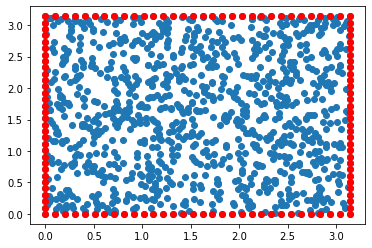

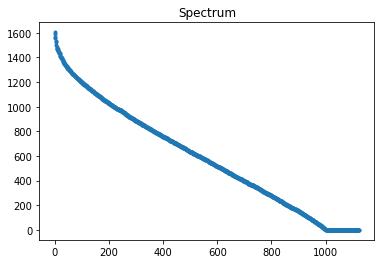

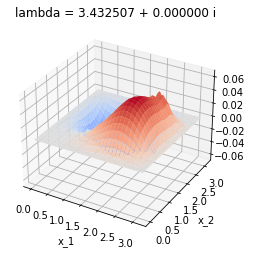

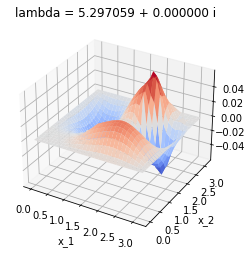

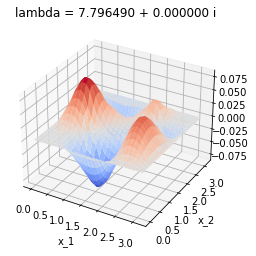

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import numpy as np
import matplotlib.pyplot as plt

from addPath import *
addPath()

from d3s import domain
from d3s import kernels
from d3s import ceig
from d3s import antisymmetricKernels as akernels

#%% two electrons in a box

# define parameters
h  = 1
m0 = 1
L  = np.pi

# define domain
bounds = np.array([[0, L], [0, L]])
boxes = np.array([31, 31])
Omega = domain.discretization(bounds, boxes)

# generate data
X, isBoundary = Omega.vertexGrid()
m = Omega.numVertices()

# replace regular grid
nr = np.count_nonzero(isBoundary)

n_new = 1000
X = np.hstack( (X[:, isBoundary], Omega.rand(n_new)) )
isBoundary = np.hstack( (np.ones(nr, dtype='bool'), np.zeros(n_new, dtype='bool') ))

m = X.shape[1]

#%% plot boundary
plt.figure(1)
plt.clf()
plt.scatter(X[0, :], X[1, :])
plt.scatter(X[0, isBoundary], X[1, isBoundary], c='red')

#%% define kernel
d = 2
sigma = 0.1
k = kernels.gaussianKernel(sigma)
k_a = akernels.antisymmetrizedKernel(k, d)

#%% set boundary conditions
G_00 = kernels.gramian(X, k_a)
N = G_00[isBoundary, :].T

#%% solve BVP
epsilon = 1e-12

G_10 = np.zeros((m, m))
for i in range(m):
    for j in range(m):
        #G_10[i, j] = -h**2/(2*m0) * k_a.laplace(X[:, i], X[:, j]) # no term related to the potential since V is 0 inside the box
        G_10[i, j] = 1/(np.abs(X[0, i] - X[1, i])+0.01) * k_a(X[:, i], X[:, j]) - h**2/(2*m0) * k_a.laplace(X[:, i], X[:, j]) 

d, V = ceig.hcgeig(G_10, G_00 + epsilon*np.eye(m), N)

# evaluate eigenfunctions in midpoints of the grid
Omega2 = domain.discretization(bounds, np.array([30, 30]))
c, _ = Omega2.vertexGrid()
W = kernels.gramian2(c, X, k_a) @ V

#%% plot spectrum
plt.figure(2)
plt.clf()
plt.plot(d, '.')
plt.title('Spectrum')

#%% plot eigenfunctions
ind, = np.where(abs(d) > 1.0)
fig = 3
for i in ind[-3:][::-1]:
    #plt.figure(fig)
    plt.figure()
    plt.clf()
    fig += 1
    #Omega.plot(np.real(W[:, i]/np.amax(abs(W[:, i]))), '3D')
    Omega2.plot(np.real(W[:, i]), '3D', grid='vertex')
    plt.title('lambda = %f + %f i' % (d[i].real, d[i].imag))
